# Test basic framework functionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [25]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import plot
import fields
import cov_model
import cokrige

## Load and view data

In [11]:
# read 5-degree monthly data and subset to US for faster testing
time = "2019-07-01"
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc")

ds

<xarray.Dataset>
Dimensions:   (lat: 35, lon: 72, time: 75)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time      (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-11-01
Data variables:
    sif       (lon, lat, time) float32 ...
    sif_var   (lon, lat, time) float32 ...
    xco2      (lon, lat, time) float32 ...
    xco2_var  (lon, lat, time) float32 ...

## Setup fields and fit empirical kernels (params from variogram model)

In [23]:
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]
Z = fields.MultiField(ds_xco2, ds_sif, "2019-07-01", timedelta=-2, detrend=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [27]:
"""
TODO: 
- look into how bin_edges are used in variogram fitting
- add option to set individual parameters manually
- don't spend too much time on the variogram approach
"""
bin_edges = np.arange(40)
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(k1, k2)._empirical_kernels(Z, bin_edges)
cokrige = cokrige.Cokrige(Z, model, fast_dist=True)

## Cokriging over XCO2 grid

In [29]:
pred_loc = Z.field_1.coords # TODO: update for entire land surface
pred, pred_err = cokrige(pred_loc)

LinAlgError: 785-th leading minor of the array is not positive definite

In [8]:
ds_pred = pd.DataFrame({"lat": Z1.coords[:,0], "lon": Z1.coords[:,1], "pred": pred}).set_index(["lon", "lat"]).to_xarray()
ds_pred["pred_err"] = pd.DataFrame({"lat": Z1.coords[:,0], "lon": Z1.coords[:,1], "pred_err": pred_err}).set_index(["lon", "lat"]).to_xarray().pred_err

ds_pred

<xarray.Dataset>
Dimensions:   (lat: 28, lon: 71)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -52.5 -47.5 -42.5 -37.5 ... 67.5 72.5 77.5 82.5
Data variables:
    pred      (lon, lat) float64 nan nan nan nan nan ... 28.85 27.6 nan nan nan
    pred_err  (lon, lat) float64 nan nan nan nan nan ... 0.01394 nan nan nan

## Plot data and results in a grid

(<GeoAxesSubplot:title={'center':'XCO$_2$: cokriging standard error'}, xlabel='lon', ylabel='lat'>,
 None)

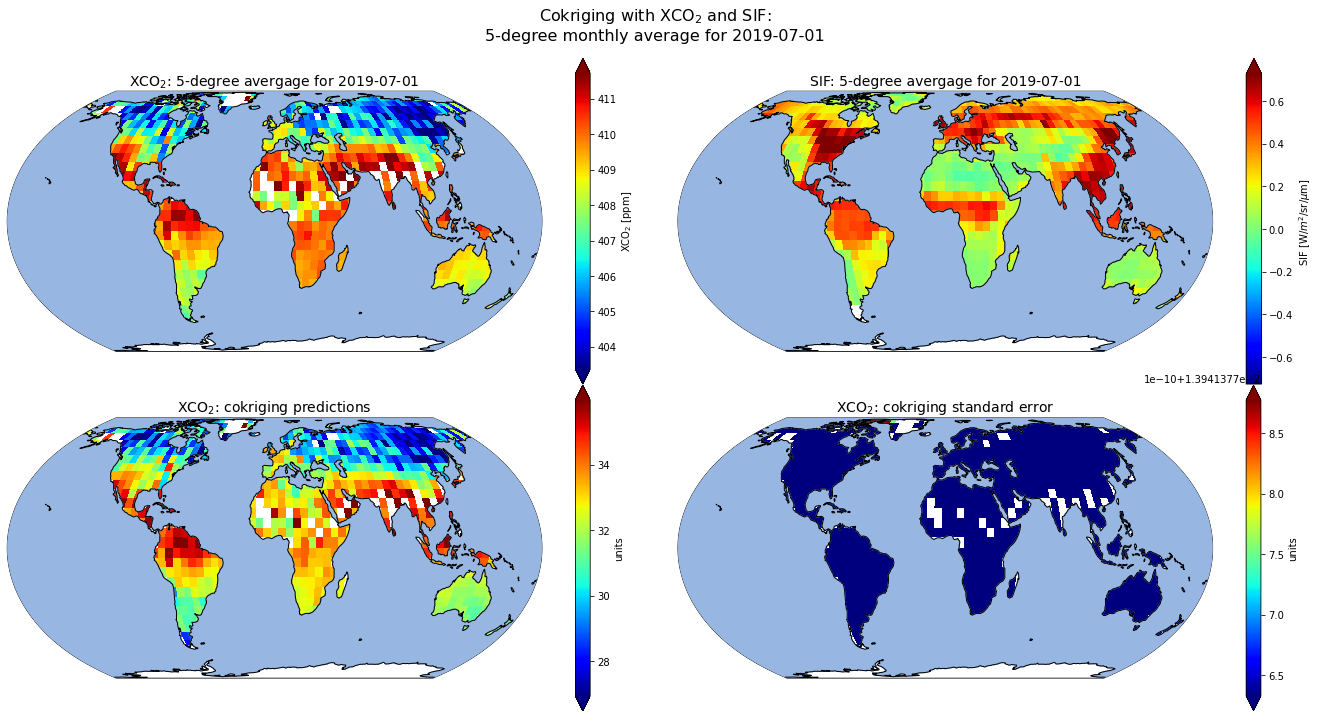

In [11]:
## TODO: find a nice way to display model parameter values in plot

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(100, 100)


# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "Cokriging with XCO$_2$ and SIF:\n"
    f"5-degree monthly average for {time}\n",
    size=16, y=0.94
)

# Input data
ax1 = fig.add_subplot(gs[0:50, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[0:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds.xco2.sel(time=time),
    title=f"XCO$_2$: 5-degree avergage for {time}",
    ax=ax1,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds.sif.sel(time=time),
    title=f"SIF: 5-degree avergage for {time}",
    ax=ax2,
    cbar_kwargs={"label": "SIF [W/$m^2$/sr/$\mu$m]"}
)

# Predictions and standard error
ax3 = fig.add_subplot(gs[50:, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[50:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds_pred.pred,
    title="XCO$_2$: cokriging predictions",
    ax=ax3,
    cbar_kwargs={"label": "units"}
)
plot.plot_da(
    ds_pred.pred_err,
    title="XCO$_2$: cokriging standard error",
    ax=ax4,
    cbar_kwargs={"label": "units"}
)

# fig.savefig("../plots/cokriging_demo.png");

In [10]:
param_values = [f"{key}: {np.round(value, 3)},\n" for key, value in model.get_params().items()]
print("Parameter values:\n" + "".join(param_values))

Parameter values:
sigma_11: 2.08,
nu_11: 19.999,
len_scale_11: 16.054,
nugget_11: 0.069,
epsilon_11: nan,
nu_12: 24.331,
len_scale_12: 14.147,
rho: -0.196,
sigma_22: 0.221,
nu_22: 28.663,
len_scale_22: 12.239,
nugget_22: 0.0,
epsilon_22: nan,

